In [84]:
### Imports
from itertools import permutations
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [90]:
### Import data
# import
train_X = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# X data info
print("X Data Info:")
print(train_X.info())
print(train_X.describe())

# separate into X and Y
train_Y = train_X.pop("Attrition")
train_Y = pd.factorize(train_Y)[0]

# Y data info
print("Y Data Info:")
print(train_Y.info())
print(train_Y.describe())

# categorical to numeric
for col in train_X.columns:
    if train_X[col].dtype == object:
        train_X[col] = pd.factorize(train_X[col])[0]
        test_data[col] = pd.factorize(test_data[col])[0]

# store column names
columns = train_X.columns

X, y = train_X, train_Y

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, 
                                                      test_size=0.2, 
                                                      random_state=0)

# turn into np array
train_X, train_Y = np.array(train_X), np.array(train_Y)
valid_X, valid_Y = np.array(valid_X), np.array(valid_Y)
test_data = np.array(test_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1340 non-null   int64 
 1   Age                       1340 non-null   int64 
 2   Attrition                 1340 non-null   object
 3   BusinessTravel            1340 non-null   object
 4   DailyRate                 1340 non-null   int64 
 5   Department                1340 non-null   object
 6   DistanceFromHome          1340 non-null   int64 
 7   Education                 1340 non-null   int64 
 8   EducationField            1340 non-null   object
 9   EmployeeCount             1340 non-null   int64 
 10  EnvironmentSatisfaction   1340 non-null   int64 
 11  Gender                    1340 non-null   object
 12  HourlyRate                1340 non-null   int64 
 13  JobInvolvement            1340 non-null   int64 
 14  JobLevel                

### Exploratory Analysis

In [101]:
### Plot data
print(train_Y)
plt.plot(train_Y)

Frequency of positive labels 0.11940298507462686


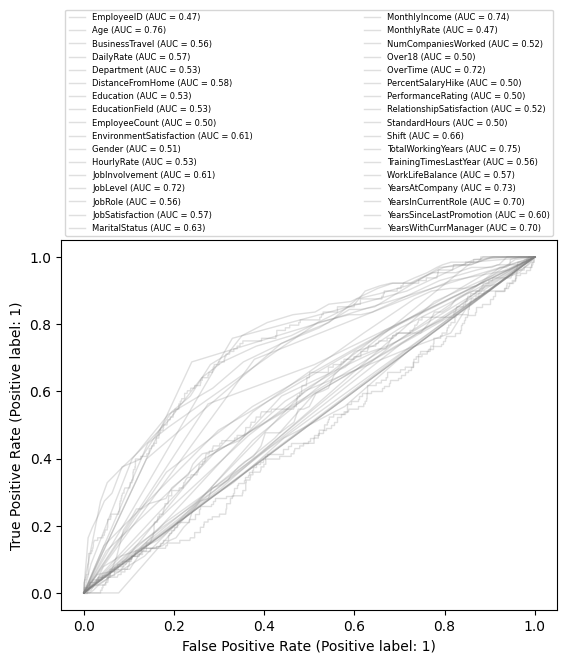

In [67]:
### ROC Curves for each feature
fig, ax = plt.subplots()

# iterate over each feature
for feat in range(train_X.shape[1]):
    feat_X = train_X[:, feat].reshape(len(train_X), 1)
    
    uni_logRegL2 = LogisticRegression(penalty="l2", random_state=2022)
    uni_logRegL2.fit(feat_X, train_Y)
    
    auc_score = roc_auc_score(train_Y, 
                              uni_logRegL2.decision_function(feat_X))
    
    RocCurveDisplay.from_estimator(uni_logRegL2, 
                   feat_X, train_Y, ax=ax, 
                   name="{num}".format(num=columns[feat]),
                   **{"alpha": 0.25, "linewidth": 1, "color": "gray"})

plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", 
           mode="expand", ncols=2, prop={'size': 6})
plt.show()

In [68]:
# Find which features are correlated with classificaiton (high AUC)

features = {}
# Find average AUC for each feature using Kfolds
for feat in range(train_X.shape[1]):
    feat_X = train_X[:, feat].reshape(len(train_X), 1)
    uni_logRegL2 = LogisticRegression(penalty="l2", random_state=2022)
    
    kf = KFold(n_splits=5)
    for train_index, valid_index in kf.split(feat_X):
        temp_train_X, temp_valid_X = feat_X[train_index], feat_X[valid_index]
        temp_train_Y, temp_valid_Y = train_Y[train_index], train_Y[valid_index]

        uni_logRegL2.fit(temp_train_X, temp_train_Y)
        auc_score = roc_auc_score(temp_valid_Y, 
                                  uni_logRegL2.decision_function(temp_valid_X))
                
        if columns[feat] not in features:
            features[columns[feat]] = np.array(auc_score)
        else:
            features[columns[feat]] = np.append(features[columns[feat]], 
                                                [auc_score])
    
    features[columns[feat]] = np.mean(features[columns[feat]])

# Sort dictionary so best average scores are first
features = {key: val for key, val in sorted(features.items(), 
            key = lambda ele: ele[1], 
            reverse = True)}

# Filter out features with lower AUC
auc_thresh = 0.60
good_features = [feature for feature, 
                 score in features.items() 
                 if score >= auc_thresh]
print(good_features)

['Age', 'TotalWorkingYears', 'MonthlyIncome', 'YearsAtCompany', 'OverTime', 'JobLevel', 'YearsWithCurrManager', 'YearsInCurrentRole', 'Shift', 'MaritalStatus', 'JobInvolvement', 'YearsSinceLastPromotion', 'EnvironmentSatisfaction']


In [92]:
### Find good perms
good_features_idx = [columns.get_loc(c) for c in good_features]

total_permutations = []
for i in range(2, 8):
    perm = combinations(good_features_idx, i+1)
    for p in perm:
        total_permutations.append(p)
print("Canidate Permutations: ", len(total_permutations))

# Find which features are not correlated with each other
# Generate feature correlation table
corr_table = pd.DataFrame(train_X).corr()
good_perms = {}

# Create correlation score for each permutation
for p in total_permutations:
    corr_score = 0
    combos = combinations(p, 2)
    
    for c in combos:
        corr_score += np.abs(corr_table[c[0]][c[1]])
    
    avg_score = corr_score / len(p)  
    good_perms[p] = avg_score

# Get 500 best combinations by lowest correlation score
NUM_COMBOS = 300
good_perms = {key: val for key, val in sorted(good_perms.items(), key = lambda ele: ele[1])}
best_perms = dict(list(good_perms.items())[:NUM_COMBOS])

Canidate Permutations:  7007


In [94]:
### LightGBM
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

# Baseline
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(train_X, train_Y, eval_metric=lgb_f1_score)

preds = lgb_model.predict(valid_X)
model_f1_score = f1_score(valid_Y, preds)
print(model_f1_score)

# lgb_model = lgb.LGBMClassifier()
# lgb_model.fit(train_X, train_Y)
# valid_accuracy = lgb_model.score(valid_X, valid_Y)
# print("Baseline Accuracy: ", valid_accuracy)

300
0.5769230769230769


In [96]:
### LightGBM
performance = {}

# iterate over all best permuations
for p in best_perms.keys():
    print(p)
    feat_X = train_X[:, list(p)]
    
    kf = KFold(n_splits=3)
    for train_index, valid_index in kf.split(feat_X):
        temp_train_X, temp_valid_X = feat_X[train_index], feat_X[valid_index]
        temp_train_Y, temp_valid_Y = train_Y[train_index], train_Y[valid_index]
        
        # fit model
        sparse_lgb_model = lgb.LGBMClassifier()
        sparse_lgb_model.fit(temp_train_X, temp_train_Y, eval_metric=lgb_f1_score)
        
        # calculate and save f1
        valid_preds = sparse_lgb_model.predict(temp_valid_X)
        valid_f1_score = f1_score(temp_valid_Y, valid_preds)
        # valid_score = sparse_lgb_model.score(temp_valid_X, temp_valid_Y)
        
        if p not in performance.keys():
            performance[p] = np.array(valid_f1_score)
        else:
            performance[p] = np.append(performance[p], [valid_f1_score])
    
    performance[p] = np.mean(performance[p])
    
# Find f and report AUC
best_params = max(performance, key=performance.get)
print("Best features (then used for f): ", best_params)
print("Valid Accuracy score for f: ", performance[best_params])


(17, 21, 26)
(21, 13, 26)
(21, 31, 12)
(30, 21, 12)
(12, 32, 9)
(21, 33, 12)
(21, 12, 32)
(31, 12, 9)
(1, 21, 12)
(30, 21, 26)
(21, 33, 26)
(17, 26, 9)
(1, 12, 9)
(17, 21, 12)
(13, 26, 9)
(33, 12, 9)
(21, 13, 12)
(27, 21, 26)
(27, 26, 9)
(21, 33, 16)
(27, 12, 9)
(21, 13, 16)
(17, 12, 9)
(30, 12, 9)
(17, 21, 16)
(30, 21, 16)
(33, 26, 9)
(13, 12, 9)
(27, 21, 12)
(21, 26, 32)
(21, 12, 9)
(26, 32, 9)
(21, 31, 26)
(17, 21, 9)
(30, 26, 9)
(1, 21, 26)
(21, 16, 12)
(27, 21, 16)
(21, 13, 9)
(17, 21, 26, 9)
(21, 26, 9)
(21, 16, 32)
(21, 31, 12, 9)
(21, 13, 26, 9)
(21, 12, 32, 9)
(21, 33, 9)
(21, 33, 12, 9)
(1, 26, 9)
(30, 21, 9)
(31, 26, 9)
(21, 31, 16)
(17, 21, 12, 9)
(30, 21, 12, 9)
(1, 21, 12, 9)
(1, 21, 16)
(33, 16, 12)
(21, 32, 9)
(21, 31, 9)
(21, 33, 16, 12)
(21, 13, 12, 9)
(16, 12, 9)
(26, 12, 9)
(16, 12, 32)
(21, 33, 26, 9)
(21, 26, 12)
(1, 21, 9)
(27, 16, 9)
(33, 16, 9)
(30, 21, 16, 12)
(21, 33, 26, 12)
(17, 21, 26, 12)
(13, 16, 9)
(27, 21, 9)
(33, 26, 12)
(30, 21, 26, 12)
(17, 16, 9)
(

In [98]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "verbosity": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [50]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 500, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000, step=25),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    NUM_SPLITS = 3
    cv = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=0)

    cv_scores = np.empty(NUM_SPLITS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        #### HERE
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=lgb_f1_score,
            callbacks=[
                lgb.early_stopping(10, verbose=0),
                lgb.log_evaluation(period=0),
                LightGBMPruningCallback(trial, "binary_logloss")
            ],
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
optuna.logging.set_verbosity(optuna.logging.FATAL)
### Make work for np
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

/Users/alexanderkumar/miniconda3/envs/671/lib/python3.8/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 1000] and step=25, but the range is not divisible by `step`. It will be replaced by [10, 985].
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/671/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'get_label'

In [73]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

tuned_lgb = lgb.LGBMClassifier(objective="binary", **study.best_params)
tuned_lgb.fit(train_X, train_Y)
valid_accuracy = tuned_lgb.score(valid_X, valid_Y)
print(valid_accuracy)

test_preds = tuned_lgb.predict(test_data)
ids = list(range(0, len(test_preds)))

output_data = pd.DataFrame({"Id": ids, "Predicted": test_preds})
output_data = output_data.set_index("Id")

output_data.to_csv("submission.csv")


	Best value (rmse): 0.36197
	Best params:
		n_estimators: 50
		learning_rate: 0.2931422982257927
		num_leaves: 410
		max_depth: 6
		min_data_in_leaf: 85
		lambda_l1: 25
		lambda_l2: 40
		min_gain_to_split: 10.759738015323492
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.759738015323492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1

In [ ]:
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
accuracy = accuracy_score(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [74]:
opt_sparse_lgb = lgb.LGBMClassifier()
opt_sparse_lgb.fit(train_X[:, list(best_params)], train_Y)

test_preds = opt_sparse_lgb.predict(test_data[:, list(best_params)])
ids = list(range(0, len(test_preds)))

output_data = pd.DataFrame({"Id": ids, "Predicted": test_preds})
output_data = output_data.set_index("Id")

output_data.to_csv("submission.csv")

In [75]:
### XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_X, train_Y)
accuracy_0 = xgb_model.score(valid_X, valid_Y)
print(accuracy_0)




0.917910447761194
